In [201]:
from qh_circuit import *
from qh_gates import *
from tn_simu import *
import qiskit
from qiskit import Aer

import matplotlib.pyplot as plt

In [202]:
def plot_state(amp):
    plt.figure()
    p = np.abs(amp) ** 2
    n = int(np.log2(len(amp)))
    label = [(r"{:0" + f"{n}" + r"b}").format(i) for i in range(len(amp))]
    plt.bar(label, p)
    plt.xticks(rotation=70)
    plt.title(f"{p.sum()}")
    plt.show()
    plt.close()


In [203]:
def rqc2(arch: TNArchitecture, depth, seed=None):
    from copy import deepcopy
    if seed is not None:
        np.random.seed(seed)
        
    nqubits = arch.nnodes
    qc = QHCircuit(nqubits)
    qqc = qiskit.QuantumCircuit(nqubits)

    edges = deepcopy(arch.edges)
    groups = []
    
    while len(edges) > 0:
        current_subset = []
        nodes_in_subset = []
        remaining_edges = []
        for edge in edges:
            u, v = edge
            if u not in nodes_in_subset and v not in nodes_in_subset:
                current_subset.append(edge)
                nodes_in_subset.append(u)
                nodes_in_subset.append(v)
            else:
                remaining_edges.append(edge)
        edges = remaining_edges

        groups.append(current_subset)
    

    qubit_history = [None for _ in range(nqubits)]
    def random_single_qubit(qubit):
        r = np.random.randint(0, 2)
        if qubit_history[qubit] == None:
            qc.t(qubit)
            qqc.t(qubit)
            qubit_history[qubit] = 't' 
        elif qubit_history[qubit] == 't':
            if r == 0:
                qc.rx(qubit, 0.5*np.pi)
                qqc.rx(0.5*np.pi, qubit)
                qubit_history[qubit] = 'rx'
            else:
                qc.ry(qubit, 0.5*np.pi)
                qqc.ry(0.5*np.pi, qubit)
                qubit_history[qubit] = 'ry'
        elif qubit_history[qubit] == 'rx':
            if r == 0:
                qc.ry(qubit, 0.5*np.pi)
                qqc.ry(0.5*np.pi, qubit)  
                qubit_history[qubit] = 'ry'  
            else:
                qc.t(qubit)
                qqc.t(qubit)
                qubit_history[qubit] = 't'  
        elif qubit_history[qubit] == 'ry':
            if r == 0:
                qc.rx(qubit, 0.5*np.pi)
                qqc.rx(0.5*np.pi, qubit)  
                qubit_history[qubit] = 'rx'  
            else:
                qc.t(qubit)
                qqc.t(qubit)
                qubit_history[qubit] = 't'  
        # p1, p2, p3 = np.random.rand(3) * 2 * 0.5*np.pi
        # qc.u(qubit, p1, p2, p3)
        # qqc.u(p1, p2, p3, qubit)

    for qubit in range(nqubits):
        qc.h(qubit)
        qqc.h(qubit)


    d = 0
    this_nodes = []
    while d < depth:
        d += 1
        edges = groups[d%len(groups)]
        # CZ gate
        remaining_nodes = list(range(nqubits))
        last_nodes = this_nodes
        this_nodes = []
        for q1, q2 in edges:
            remaining_nodes.remove(q1)
            remaining_nodes.remove(q2)
            this_nodes += [q1, q2]

            if np.random.rand() < 0.5:
                qc.cz(q1, q2)
                qqc.cz(q1, q2)
            else:
                qc.cz(q2, q1)
                qqc.cz(q2, q1)

            random_single_qubit(q1)
            random_single_qubit(q2)

        # print(f"d={d}; Remain {remaining_nodes}; last {last_nodes}")
        # for qubit in remaining_nodes:
            # if qubit in last_nodes:
                # random_single_qubit(qubit)

        # for qubit in remaining_nodes:
            # random_single_qubit(qubit)
        
        # Single-qubit gate 
        # for qubit in range(nqubits):
            # random_single_qubit(qubit)

    for qubit in range(nqubits):
        qc.h(qubit)
        qqc.h(qubit) 


    return qc, qqc

In [204]:
def get_distribution_statistis(probs, log=False):
    if log:
    # N = len(probs)
        m1 = np.log(np.mean(probs))
        m2 = np.log(np.mean(probs**2))
        m3 = np.log(np.mean(probs**3))
        m4 = np.log(np.mean(probs**4))
        probs_non_zero = probs[probs != 0]
        entropy = -(probs_non_zero * np.log(probs_non_zero)).sum()


    return np.array([m1, m2, m3, m4, entropy])

In [205]:
N = 2**65
loge2 = np.log(2)
logN = loge2 * 65
# np.log(1) - np.log(N), np.log(2 / N**2), np.log(6 / N**3), np.log(24 / N**4), np.log(N) - 1 + 0.5772156649

In [206]:
arch = IBM65Architecture()
# arch.edges.append((0,7))
arch.compute_neighbours()
circuit, _ = rqc2(arch, 16, 123)
print(len(circuit.instructions))
simu = TNSimulator(arch, circuit, 0.0001, max_chi=24)
simu.contraction_order = list(range(27)) + [29, 28, 27] + list(range(30, 55)) + [56, 55] + list(range(57, 65))

994


In [207]:
simu.simulate(method='qr-svd')
simu.get_statistics()
simu.compute_contraction_flop()

Highest degree: 3; Max bond dimension: 24
Max number of parameters:     496608 (8 MiB)
Current number of parameters: 155200 (2 MiB)


130523136

In [208]:
amp = []

In [209]:
nsamples = 1000


In [226]:
amp = list(amp) + list(simu.sample_amplitudes(int(nsamples)))
amp = np.array(amp)

100%|██████████| 1000/1000 [03:20<00:00,  4.99it/s]


In [211]:
probs = np.abs(amp) ** 2
logprobs = np.log(probs)
print(len(amp))
np.exp(logprobs).sum() * N / len(amp)

1000


0.996684809619335

In [235]:
density, divide = np.histogram(probs, bins=40, density=True)
divide = (divide[1:] + divide[:-1]) / 2

In [236]:
# density

In [237]:
import matplotlib.pylab as pylab
pylab.rcParams.update({
    'legend.fontsize': 'large',
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'large',
    'ytick.labelsize': 'large',
})

/tmp/ipykernel_32048/2158044181.py:4: RuntimeWarning: divide by zero encountered in log
  ax.plot(divide, np.log(density), '.', label='Sampled')


Text(0.5, 1.0, 'RQC Simulation of IBM Ithaca (65 qubits)')

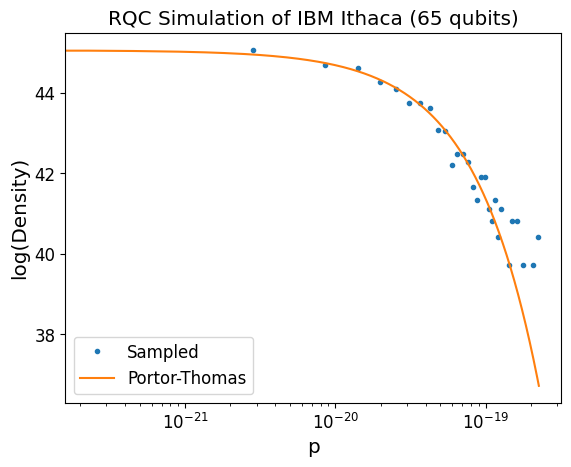

In [239]:
fig, ax = plt.subplots()
# from math import exp

ax.plot(divide, np.log(density), '.', label='Sampled')

p = np.linspace(0, probs.max(), 1000)
logy = logN - N*p

ax.plot(p, logy, label="Portor-Thomas")

ax.semilogx()

plt.xlabel("p")
plt.ylabel("log(Density)")


plt.legend()
plt.title("RQC Simulation of IBM Ithaca (65 qubits)")

In [215]:
logy.max(), logy.min()

(45.054566736396445, 36.71903923298734)